In [1]:
import numpy as np, prjlib, plottools as pl, healpy as hp, pickle, curvedsky, delens_tools, misctools
from matplotlib.pyplot import *

In [2]:
p, f, r = prjlib.analysis_init(t='la',freq='coadd',snmin=1,snmax=10,rlmin=500,rlmax=3000,qlist=['TT','TE','EE','EB'])
__, fsa, __ = prjlib.analysis_init(t='sa',freq='coadd')
fid = prjlib.filename_init(t='id')
p.quad.qlist.extend(['PO','TP'])

In [3]:
wfac = {}
Wla, Mla, wfac['fsky'], wfac['w1'], wfac['w2'], wfac['w4'] = prjlib.window(f.cmb.mask)
Wla = hp.pixelfunc.ud_grade(Wla,p.nside)

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.5752538045247396 0.14110664609279655 0.046519878502273154 0.00878600382491057


In [4]:
skmap, nkmap, wkmap = {}, {}, {}
#wlk = prjlib.Wiener_Lensing(p.quad.f,r.kk,p.dlmin,p.dlmax,qlist=p.quad.qlist)
for nside0, nside1 in [(32,64),(64,128),(128,256),(256,512),(512,1024)]:
    lmin, lmax = 2*nside0, 2*nside1
    wla = hp.pixelfunc.ud_grade(Wla,nside1)
    mla = wla/(wla+1e-30)
    vkap = {}
    for q in ['TT']:
        vkap[q], skap = 0., 0.
    for i in p.rlz:
        misctools.progress(i,p.rlz,addtext='(nside1='+str(nside1)+')')
        klm = delens_tools.prep_klms(p.quad.f,i,lmax,wfac=wfac,remove_mean=True,qlist=p.quad.qlist)
        iklm = prjlib.load_input_plm(f.palm[i],p.dlmax,kL=r.kL)
        iklm = prjlib.multiplywindow(Wla,p.npix,p.nside,p.dlmax,iklm)
        iklm[:lmin,:] = 0.
        for q in ['TT']:
            wklm = klm[q]#*wlk[q][:lmax+1,None]
            wklm[:lmin,:] = 0.
            vkap[q] += (curvedsky.utils.hp_alm2map(12*nside1**2,lmax,lmax,wklm-iklm[:lmax+1,:lmax+1]))**2/len(p.rlz)
        skap += (curvedsky.utils.hp_alm2map(12*nside1**2,lmax,lmax,iklm[:lmax+1,:lmax+1]))**2/len(p.rlz)
    #for q in ['TT','TE','EE','EB','PO','TP']:
    nkmap[nside1] = mla*np.sqrt(vkap['TT']/wfac['w4'])
    skmap[nside1] = mla*np.sqrt(skap/wfac['w2'])
    wkmap[nside1] = skmap[nside1]/(skmap[nside1]+nkmap[nside1]+1e-30)
    pickle.dump((skmap[nside1],nkmap[nside1],wkmap[nside1]),open('trash/tmp_w_'+str(nside1)+'.pkl',"wb"),protocol=pickle.HIGHEST_PROTOCOL)

Current progress (nside1=1024): 90.0 %


64
128
256
512
1024


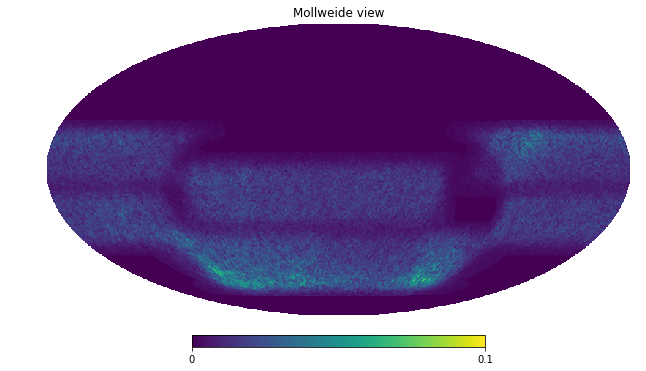

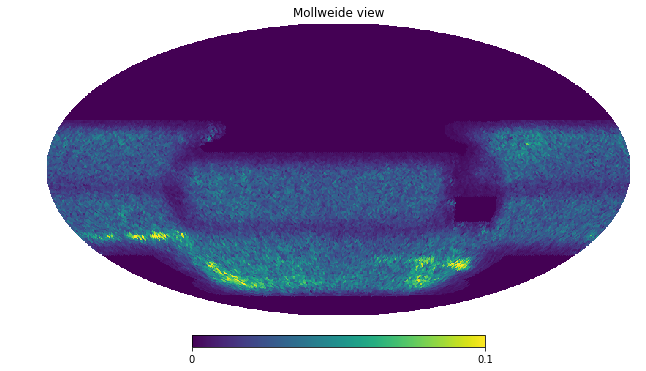

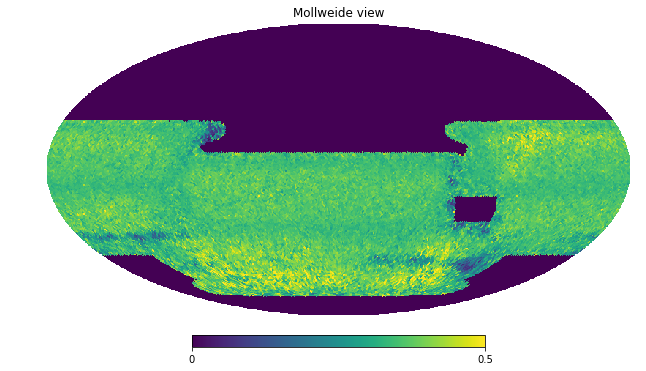

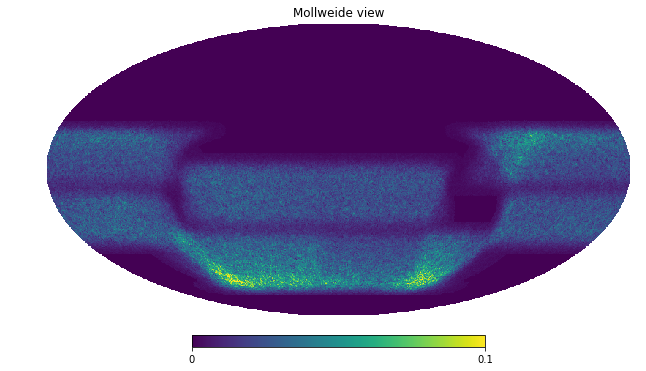

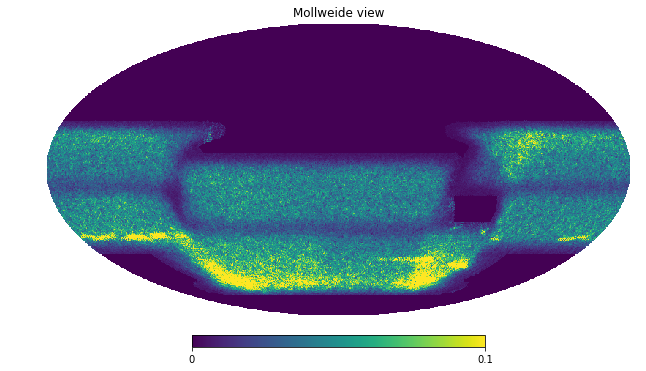

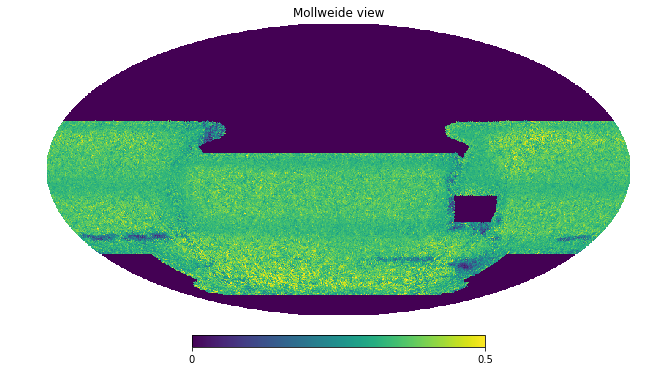

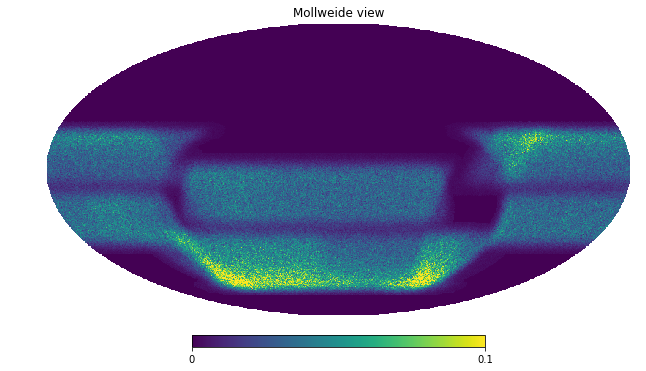

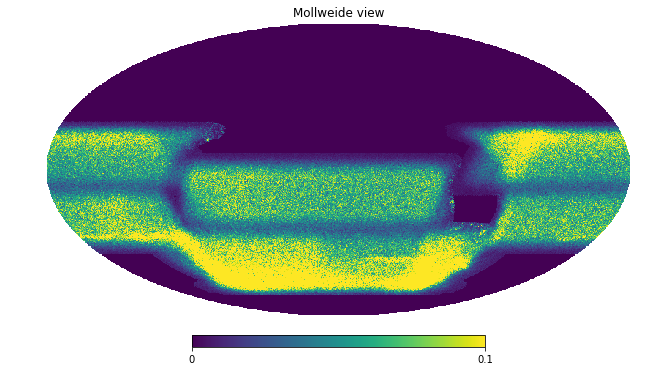

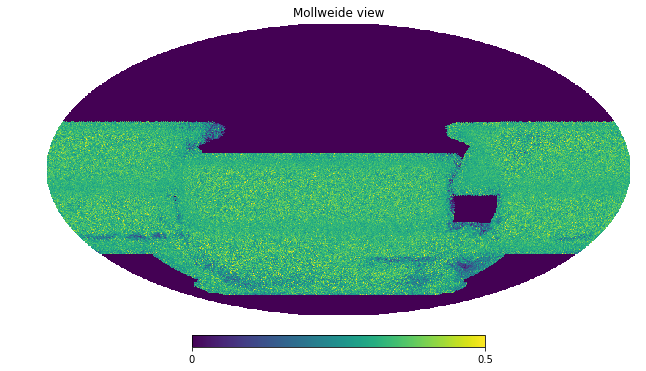

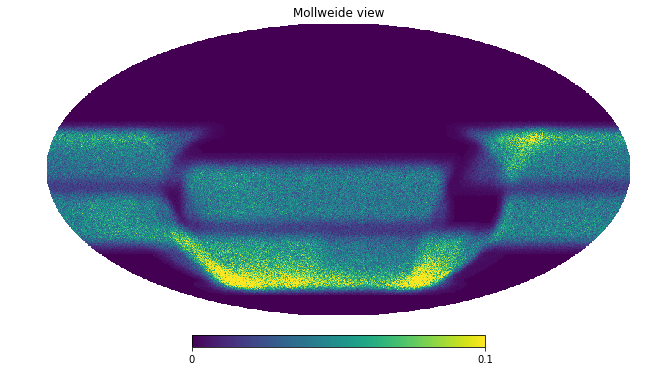

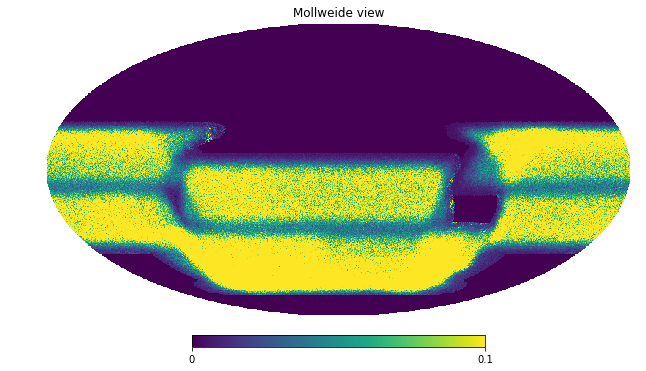

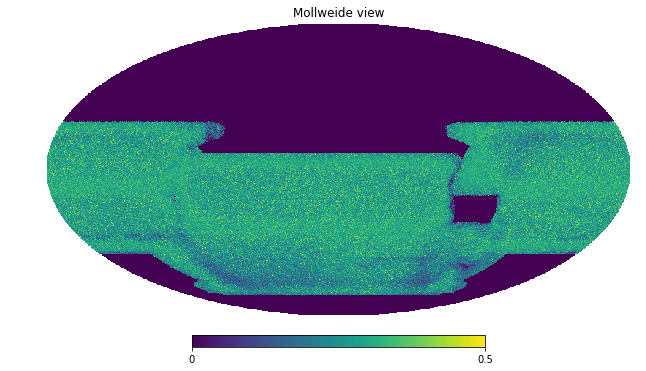

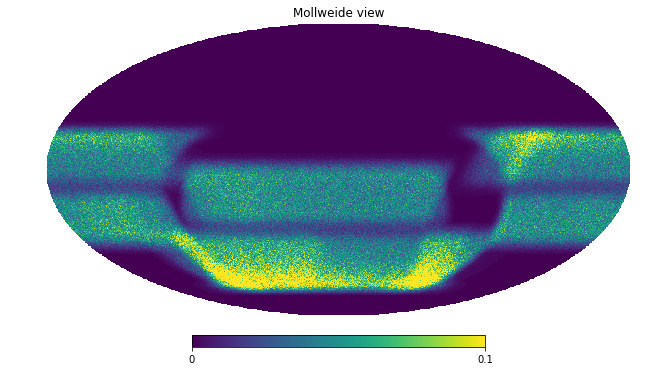

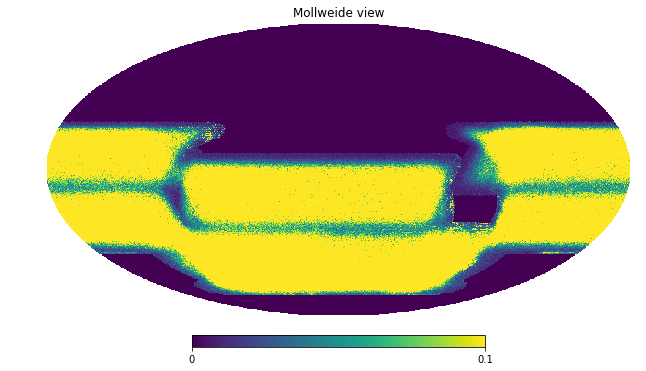

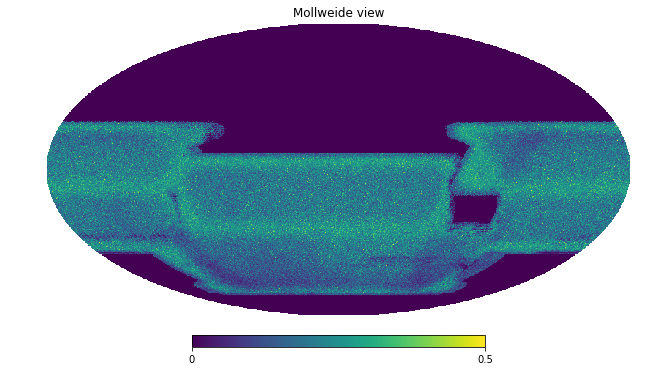

In [5]:
for nside0, nside1 in [(32,64),(64,128),(128,256),(256,512),(512,1024)]:
    print(nside1)
    hp.mollview(skmap[nside1],min=0,max=.1)
    hp.mollview(nkmap[nside1],min=0,max=.1)
    hp.mollview(wkmap[nside1],min=0,max=.5)

In [6]:
iklm[:lmin,:] = 0.
wklm[:lmin,:] = 0.
kapTT = curvedsky.utils.hp_alm2map(12*nside**2,lmax,lmax,wklm[:lmax+1,:lmax+1])/wfac['w2']
hp.mollview(kapTT,min=-.05,max=.05)
savefig('fig_rkap.png')
ikap = mla*curvedsky.utils.hp_alm2map(12*nside**2,lmax,lmax,iklm[:lmax+1,:lmax+1])/wfac['w1']
hp.mollview(ikap,min=-.05,max=.05)
savefig('fig_ikap.png')
#hp.mollview(kapTT-ikap,min=-.05,max=.05)
#kapEE = curvedsky.utils.hp_alm2map(12*nside**2,lmax,lmax,wklm['EE'][lmin:lmax+1,lmin:lmax+1])/wfac['fsky']
#hp.mollview(kapEE,min=-.05,max=.05)

NameError: name 'nside' is not defined

In [ ]:
'''
#for q in ['TT','TE','EE','EB','PO','IN','TP']:
for q in ['TT']:
    if q=='TT':
        norm = wfac['w2']
    elif q=='IN': 
        norm = 1.
    elif q=='TE': 
        norm = wfac['w1']
    else: 
        norm = wfac['fsky']
    print(q,norm)
    if q!='IN':
        nkmap = mla*np.sqrt(vkap[q]/wfac['w4'])
        skmap = mla*np.sqrt(skap/wfac['w2'])
        rmask4 = (wla/np.max(wla))**2/(nkmap+1e-30)
        rmask2 = (wla/np.max(wla))**1/(nkmap+1e-30)
        #iwla = 1./((wla/np.max(wla))**2+1e-30)
        #iwla[iwla>1e20] = 0.
        hp.mollview(nkmap,min=0,max=.1)
        hp.mollview(skmap,min=0,max=.1)
        hp.mollview(skmap/(skmap+nkmap+1e-30),min=0,max=.5)
        hp.mollview((wla/np.max(wla))**2,min=0,max=.1)
        #hp.mollview(iwla,min=0,max=20)
        hp.mollview(rmask4,min=0,max=6)
        hp.mollview(rmask2,min=0,max=20)
        #ckap = wla*curvedsky.utils.hp_alm2map(12*nside**2,lmax,lmax,wclm[q][:lmax+1,:lmax+1])/norm
        #wkap = wla * ckap/(vkap[q]/norm**2+1e-30) / wfac['w1']
        #hp.mollview(wkap,min=-.0005,max=.0005)
        #ikap = wla/(wla+1e-30)*curvedsky.utils.hp_alm2map(12*nside**2,lmax,lmax,wilm[q][:lmax+1,:lmax+1])/norm
        #hp.mollview(ikap,min=-.1,max=.1)
        #print(np.mean(wkap),np.std(wkap),np.std(ikap))
    show()
    clf()
    #if q not in ['IN','PO','TP']:
    #    kap = curvedsky.utils.hp_alm2map(12*nside**2,lmax,lmax,wmlm[q][:lmax+1,:lmax+1])/norm
    #    hp.mollview(kap,min=-.05,max=.05)
    #    show()
    #    clf()
'''